<a href="https://colab.research.google.com/github/MarkStephens060482/MarkStephens060482/blob/main/Kernels_of_SVM_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating Kernels of Support Vector Classifiers

### Scenario  
*The goal is to practice your prediction skills on an existing dataset. You will be using the diabetes dataset available in Scikit-learn and you will be predicting the disease progression. The dataset represents values of various physiological variables of various patients over a year.
You have been asked to propose a predictor with the best performance on this dataset when compared to a naive and regression baseline.* 

***
### Your tasks  
1. Write code to load the dataset and run the machine learning pipeline using SVR with different kernels. You can use the kernels you’ve learned about in this course, or other kernels. 
2. Create a naive baseline and a compare two kernels using RMSE. Perform hyperparameter tuning for your model. 
3. Create a regression baseline and compare two kernels using RMSE. Perform hyperparameter tuning for your model. 

In [ ]:
#load important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#from sklearn.model_selection import 

# load the dataset
diabetes = load_diabetes(scaled = False)

#add feature variables to dataframe
df_diabetes = pd.DataFrame(diabetes.data,
                           columns = diabetes.feature_names)
#add target variable, disease_progress, to dataframe.
df_diabetes['disease_progression']=diabetes.target

In [ ]:
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease_progression
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


### Data Pre-processing
Examine dataset for missing values

In [ ]:
df_diabetes.isnull().sum()

age                    0
sex                    0
bmi                    0
bp                     0
s1                     0
s2                     0
s3                     0
s4                     0
s5                     0
s6                     0
disease_progression    0
dtype: int64

The assumptions of Support Vector Machine for regression is that the predictor variables are:
Independent and identically distributed. Examine the correlation of preedictors and outcome variables, as well as the distribution of the variables.

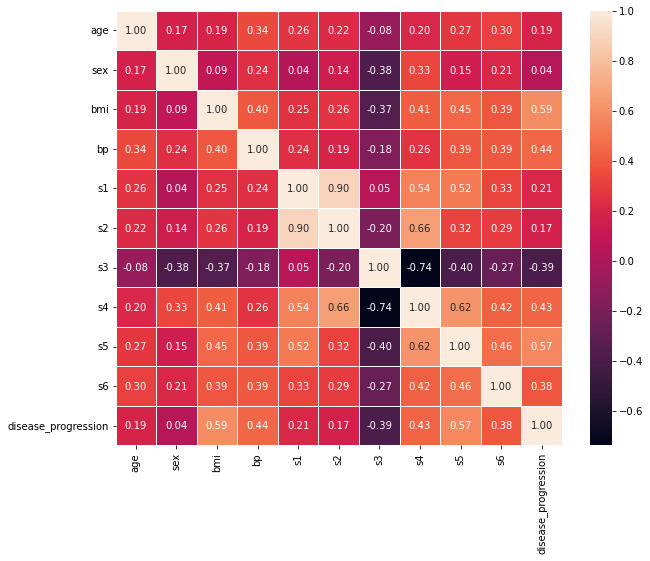

In [ ]:
diabetes_corr = df_diabetes.corr()
plt.figure(figsize=(10,8))
sns.heatmap(data=diabetes_corr, annot = True, fmt='.2f', linewidths=.5)
plt.show()

The correlation heatmap indicates that the features 'sex', 's2' and 'age' are least correlated with the outcome 'disease_progression', however as all predictors are not significantly correlated to the target variable, all will be considered to inform the model.
The predictors 's1' and 's2' are highly correlated with a coefficient of 0.9 and therefore not independent of each other. Also, the predictors 's3' and 's4' are also moderately correlated with each other and exhibit a degree of dependency. The predictors that are significantly correlated to other predictors though minimally correlated to the target variable are not to be retained as features of the model.

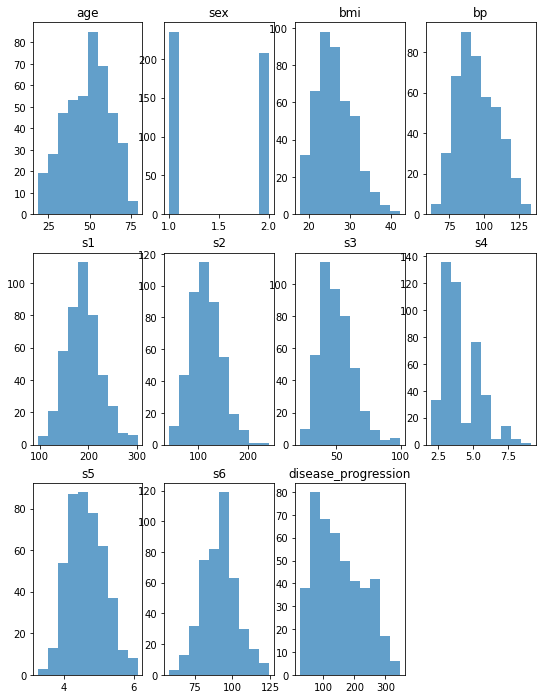

In [ ]:
# Produce histograms of predictors and outcome variable

# number of rows in subplot
rows = int(np.floor(np.sqrt(len(df_diabetes.columns)))) 
# number of columns in subplot
cols = int(np.ceil(len(df_diabetes.columns)/rows))

fig,axs = plt.subplots(rows,cols, figsize = (3*rows,3*cols)) # produce a figure

#loop for each subplot 
for idx, ax in enumerate(axs.ravel()):
    if idx==len(df_diabetes.columns):
        break;
    ax.hist(df_diabetes.iloc[:,idx], alpha = 0.7)
    ax.set_title(df_diabetes.columns[idx])
ax.remove()
plt.show()
    

The continuous numeric variables are approximately normally distributed, with slight skew. The variable 's4' has the least similar distribution, being bi-modal, as well as the categorical variable 'sex', which is a binary variable. The variables that are least correlated to the target variable, 'disease_progression', and exhibit a lack of independence are to be excluded from the model.

In [ ]:
# identifying predictors that exhibit correlation with target variable greater than a threshold
threshold = 0.1 # consider all predictors
#features = diabetes_corr.disease_progression[abs(diabetes_corr.disease_progression) > 0.3].index.tolist()
features = diabetes_corr.disease_progression[abs(diabetes_corr.disease_progression) > threshold].index.tolist()
# removing the variable that moderately correlated to another predictor, 's3'.
#features.remove(['s3'])
features.remove('s2')
features.remove('s4')
#dataframe with selected features 
df_diabetes = df_diabetes[features]

Define the features and target variable to feed the model

In [ ]:
# features for the model
X = df_diabetes.drop(columns = 'disease_progression')

# target variable for the model
y = df_diabetes.disease_progression

Define functions that return the naive baseline and dummy regressor baseline measure of RMSE with cros validation.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor


def naive_RSME(y, y_test):
    baseline = np.mean(y)
    y_baseline = np.repeat(baseline, len(y_test))
    n_MSE = mean_squared_error(y_test, y_baseline)
    naive_RSME=np.sqrt(n_MSE)
    return naive_RSME

def dummy_RMSE(X_train, X_test, y_train, y_test): 
    lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
    y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
    dummy_MSE = mean_squared_error(y_test, y_predict_dummy_mean)
    dummy_RMSE = np.sqrt(dummy_MSE)
    return dummy_RMSE

### Defining the models

The Support Vector Machine Regressor models are defined with the following kernel functions:
1. linear
2. polynomial
3. radial base function
4. sigmoid function

The data is standardised  with centre and scaling as part of the pre-processing step of the pipelines. The Support Vector Machine regressors are fitted to the whole dataset for the different kernels and the training performance is assessed with RMSE score under repeated k-fold cross validation. The models are compared against the naive baseline measure of performance .

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
# define a minmax scaler to normalise minmax
scaler = StandardScaler()

#defining the kernel functions for the SVR estimator
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

#initialise a repeated k-fold cross validation
folds = 5
repeats = 10
cv = RepeatedKFold(n_splits = folds, n_repeats = repeats, random_state=20)
new_line = '\n'
untuned_results = []
for kernel in kernels:
    # define the model for the different 
    regressor = SVR(kernel = kernel)
    # make a pipeline
    svr_pipe = make_pipeline(scaler,regressor)
    
    #fit the model model on training data
    svr_pipe.fit(X,y)
    
    # predict on the training data
    svr_train_predict = svr_pipe.predict(X)
    
    # compute a set of cross-validation scores of RMSE    
    cv_scores = -1*cross_val_score(svr_pipe,X,y,cv = cv,scoring = 'neg_root_mean_squared_error',n_jobs=-1)
    
    #calculate the mean of the RMSE scores under cross-validation
    mean_cv_score = round(cv_scores.mean(),2)
    # calculate the standard error of the mean of the RMSE scores under cross-validation
    sterr_cv_score = round(cv_scores.std()/np.sqrt(folds*repeats),2) 
    untuned_results.append(str(mean_cv_score) + " \u00B1 " + str(2*sterr_cv_score))
    
    #margin of error for 95% confidence interval
    print(f'The training performance RMSE of the untuned SVR with {kernel} kernel is: {new_line}\
    {mean_cv_score} \u00B1 {2*sterr_cv_score} (95%CI)')
    

The training performance RMSE of the untuned SVR with linear kernel is: 
    56.19 ± 0.84 (95%CI)
The training performance RMSE of the untuned SVR with poly kernel is: 
    64.18 ± 0.84 (95%CI)
The training performance RMSE of the untuned SVR with rbf kernel is: 
    69.6 ± 0.98 (95%CI)
The training performance RMSE of the untuned SVR with sigmoid kernel is: 
    59.8 ± 0.78 (95%CI)


Establish a naive baseline score of RMSE using a dummy regressor employing mean value regression based on the whole data set.

In [ ]:
#score_baeline1 = naive_RSME(y, y_test)
    
score_baeline1 = dummy_RMSE(X, X, y, y)

print(f"Naive baseline  of RMSE = {round(score_baeline1,2)}")

Naive baseline  of RMSE = 77.01


### Segregation
Segregate data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=15)
new_line = '\n'
print(f'Training dataset:{new_line}\
X_train = { X_train.shape} {new_line}\
y_train = { y_train.shape}{new_line}')

print(f'Testing dataset:{new_line}\
X_test = {X_test.shape}{new_line}\
y_test = {y_test.shape}')

Training dataset:
X_train = (353, 7) 
y_train = (353,)

Testing dataset:
X_test = (89, 7)
y_test = (89,)


The hyper parameter space is define for the hyper parameters *Gamma*, Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’, and *C*, regularization parameter. Also, the other hyper-parameters are assigned a range of values, them being *degree*, degree of the polynomial kernel function, and *epsilon*, specifying the epsilon-tube within which no penalty is associated in the training loss function. 
A **for** loop is used to iterate through the list of kernels and a model and pipline are defined for each.

In [ ]:
from sklearn.model_selection import GridSearchCV

#defining the hyperparameter space ranges
C_range = np.logspace(-1, 2.5, 12)
gamma_range = np.logspace(-3, -0.5, 12)

# hyperparameter grid
param_grid = {'svr__C':C_range,
              'svr__gamma':gamma_range,
              'svr__degree':[2,3,4],
              'svr__epsilon':[0.1,1,5,10,15,20]}

#Support Vector Machine Regressors hyperparameter tuning
tuned_model_results = []
tuned_models = [] 
gscv_folds = 5
for kernel in kernels:
    # define the model for the different 
    regressor = SVR(kernel = kernel)
    # make a pipeline
    svr_pipe = make_pipeline(scaler,regressor)
    
    # define a gridsearch
    svr_grid = GridSearchCV(estimator = svr_pipe,
                        param_grid = param_grid,
                        scoring = 'neg_root_mean_squared_error',
                        #verbose = 10,
                        n_jobs = -1,
                        cv = gscv_folds)
    #fit the model along the hyperparameter space
    svr_grid.fit(X_train,y_train)
    
    # best mean cross-validation RMSE score
    mean_gridcv = round(-1*svr_grid.best_score_,2)
    # standard error of mean cross-validation RMSE score
    sterr_gridcv = round((svr_grid.cv_results_['std_test_score'][svr_grid.best_index_])/np.sqrt(folds),2)
    
    tuned_models.append(svr_grid)   
    tuned_model_results.append(str(mean_gridcv)+" \u00B1 "+str(2*sterr_gridcv))
    
    # give best cross validation score with 95% confidence interval. 
    print(f'{kernel} kernel for SVR estimator with tuned parameters = {svr_grid.best_params_}{new_line}\
    Best mean cross validation score = {mean_gridcv} \u00B1 {2*sterr_gridcv} (95%CI).{new_line}')

linear kernel for SVR estimator with tuned parameters = {'svr__C': 8.111308307896872, 'svr__degree': 2, 'svr__epsilon': 10, 'svr__gamma': 0.001}
    Best mean cross validation score = 55.91 ± 1.86 (95%CI).

poly kernel for SVR estimator with tuned parameters = {'svr__C': 73.05271542664457, 'svr__degree': 3, 'svr__epsilon': 10, 'svr__gamma': 0.0657933224657568}
    Best mean cross validation score = 62.37 ± 2.66 (95%CI).

rbf kernel for SVR estimator with tuned parameters = {'svr__C': 73.05271542664457, 'svr__degree': 2, 'svr__epsilon': 15, 'svr__gamma': 0.013688745095370805}
    Best mean cross validation score = 55.67 ± 1.32 (95%CI).

sigmoid kernel for SVR estimator with tuned parameters = {'svr__C': 151.99110829529332, 'svr__degree': 2, 'svr__epsilon': 20, 'svr__gamma': 0.038986037025490715}
    Best mean cross validation score = 55.75 ± 1.84 (95%CI).



### Evaluate on test data
The tuned Support Vector Machine Regressors are evaluated on unseen test data.

In [ ]:
test_results = []
# loop through the tuned models and evaluate performance
for i,tuned_model in enumerate(tuned_models):
    #form predictions on test data
    y_pred = tuned_model.predict(X_test)
    # evaluate performance with RMSE
    performance_score = round(np.sqrt(mean_squared_error(y_test,y_pred)),2)
    test_results.append(performance_score)
    
    print(f'The SVR with {kernels[i]} kernel, the RMSE on test data is: {performance_score}.{new_line}') 

The SVR with linear kernel, the RMSE on test data is: 54.42.

The SVR with poly kernel, the RMSE on test data is: 61.89.

The SVR with rbf kernel, the RMSE on test data is: 52.68.

The SVR with sigmoid kernel, the RMSE on test data is: 54.44.



### Summary of results
A summary of results giving the Root Mean Squared Error for naive baseline, untuned and tuned model training as well as for final model performance on test data.

In [ ]:
pd.DataFrame(np.c_[pd.Series(kernels),
                   pd.Series(np.repeat(round(score_baeline1,2),len(kernels))),
                   pd.Series(untuned_results),
                   pd.Series(tuned_model_results),
                   pd.Series(test_results)],
             columns = ['SVR kernel functions',
                        'naive baseline RMSE',
                        'untuned training RMSE under CV',
                        'tuned training RMSE under CV',
                        "Model performance RMSE"])
                

,SVR kernel functions,naive baseline RMSE,untuned training RMSE under CV,tuned training RMSE under CV,Model performance RMSE
0,linear,77.01,56.19 ± 0.84,55.91 ± 1.86,54.42
1,poly,77.01,64.18 ± 0.84,62.37 ± 2.66,61.89
2,rbf,77.01,69.6 ± 0.98,55.67 ± 1.32,52.68
3,sigmoid,77.01,59.8 ± 0.78,55.75 ± 1.84,54.44
